# Telecom Churn Project 

## A simple financial simulation

After all the models were tested and a winner was selected it's always useful to look at how deploying a model might impact the business.  This notebook looks at a simple simulation of promotion cost, promotion acceptance and different thresholds for logistic regression classifier.

In [3]:
import os
import sys
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go

# These are tools that I created for model data generation
sys.path.append('../src')
from my_eval_tools import calc_roc_data
from my_eval_tools import calc_hybrid_roc_data 
from my_eval_tools import hybrid_predict, hybrid_predict_proba
from my_eval_tools import calc_pr_sweep
from my_eval_tools import predict_sweep


In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

Using TensorFlow backend.


Read the training data file.  This csv file was created from the original Telecom data file and was cleaned and scaled before it was put into a second csv file to make a milestone for this work.  Specifically, this file was created by running the notebooks:
* Telecom to SQL
* Telecom clean and eda

In [5]:
# Read the csv file save by the clean/eda notebook
train_df = pd.read_csv('../data/churn_train_clean.csv').drop('Unnamed: 0', axis=1)


In [6]:
# Define which columns we're going to use in our modeling.
train_columns1 = ['SeniorCitizen', 'Partner', 'Dependents', \
       'tenure', 'PhoneService', 'MultipleLines',  \
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', \
       'StreamingTV', 'StreamingMovies', 'MonthlyCharges', 'TotalCharges', \
       'Month-to-month', 'One year', 'Fiber optic', 'Female']

train_columns2 = ['SeniorCitizen', 'Partner', 'Dependents', \
       'tenure', 'PhoneService', 'MultipleLines',  \
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', \
       'StreamingTV', 'StreamingMovies', \
       'Month-to-month', 'One year', 'Fiber optic', 'MonthlyCharges', 'Female']

train_columns = train_columns2

X = train_df[train_columns]
y= train_df['Churn']

In [7]:
# Split the original dataset into train and validation groups
#  set stratify to true so both classes are represented it the splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Make a balance set for model training
sm = SMOTE(random_state=42)
X_train_smt, y_train_smt = sm.fit_resample(X_train, y_train)

In [8]:
log_best = LogisticRegression(C=0.03, penalty='l2', solver='liblinear', random_state=45)
log_best.fit(X_train_smt,y_train_smt)


LogisticRegression(C=0.03, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=45, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Financial Implications

Obviously doing nothing will mean siginificant loss of revenue for the company.  Conversely, offering an incentive to all customers would result in unnecessary expenses for content customers.  We need to find a happy middle ground.

Average monthly charges per customer are $64.76.  Our full dataset has<br>
> Yes    1869 <br>
> No    5174 <br>

Which translates to a 27% churn rate or a $121,036 potential loss in revenue.<br>

Month to month contracts were highlighted as the most important feature by the Random Forest classifier.  This makes sense as month to month customers are most likely to actively price shop their service.  In the pilot test dataset the contract type breakdown is: <br>
> Month-to-month    3875 <br>
> One year    1473<br>
> Two year   1695<br>

Within each of these categories we see the following:

<table style='width:50%', align='left'>
    <tr>
        <th>Contract</th>
        <th>Churn</th>
        <th></th>
    </tr>
    <tr>
        <td>Month-to-month</td>
        <td>No</td>
        <td>2220</td>
    </tr>
     <tr> 
        <td> </td>
        <td>Yes</td>
        <td>1655</td>
    </tr>
    <tr> 
        <td>One year</td>
        <td>No</td>
        <td>1307</td>
    </tr>
    <tr> 
        <td> </td>
        <td>Yes</td>
        <td>166</td>
    </tr>
    <tr> 
        <td>Two year</td>
        <td>No</td>
        <td>1647</td>
    </tr>
    <tr> 
        <td></td>
        <td>Yes</td>
        <td>48</td>
    </tr>
</table><br><br><br><br><br><br><br><br><br><br><br>

So even within the month to month contract group those who churn are only 43%.  If we can correctly identify those customers and target the incentive we can reduce the incentive costs without reducing our retention rate.


So for an incentive plan:

Churn Reduction = Base Churn Rate * Recall  * Acceptance Rate<br>
<br>
New Churn = Base Churn - Churn Reduction = Base Churn (1 - Recall * Acceptance)

Incentive Cost = (tp + fp) / (tp + fp + fn + tn) * Acceptance Rate * Incentive Cost

In [9]:
results = predict_sweep(log_best.predict_proba, X_test, y_test, 20)

In [10]:
ave_monthly_charges = 64.76 # from the full dataset

promo_cost = 0.04 * ave_monthly_charges
promo_acceptance_rate = 0.5


base_churn = 0.022 # 2.2 percent monthly churn
customer_pop = 1869+5174


incentive_cost_list = []
churn_cost_list = []
threshold_list = []
total_cost_list = []

base_churn_cost = base_churn * ave_monthly_charges * customer_pop

for result in results :
    threshold = result[0]
    tn = result[1]
    fp = result[2]
    fn = result[3]
    tp = result[4]
    
    new_churn = base_churn * ( 1 - tp / (tp + fn) * promo_acceptance_rate)

    churn_cost = new_churn * ave_monthly_charges * customer_pop
    
    incentive_cost = (tp+fp)/(tp+fp+fn+tn) * promo_acceptance_rate * promo_cost * customer_pop
    total_cost = churn_cost + incentive_cost
    
    churn_cost_list.append(churn_cost)
    incentive_cost_list.append(incentive_cost)
    threshold_list.append(threshold)
    total_cost_list.append(total_cost)

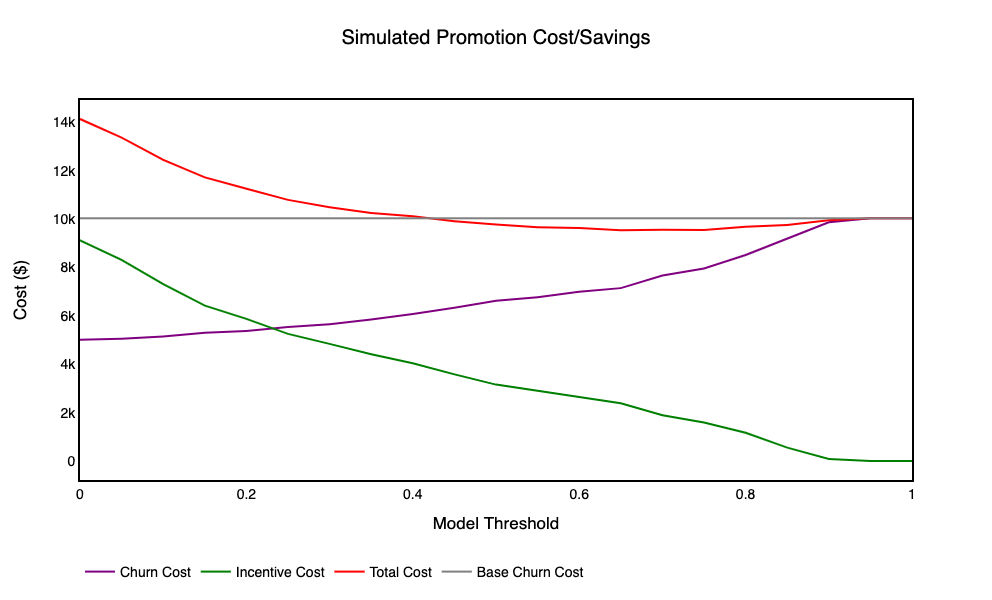

In [14]:
'''fig = plt.figure(figsize = [14,8])

fig.patch.set_alpha(0.)

plt.plot(threshold_list, churn_cost_list, label='Churn cost')
plt.plot(threshold_list, incentive_cost_list, label='Incentive cost')
plt.plot(threshold_list, total_cost_list, label='Total cost')
plt.plot([0,1],[base_churn_cost, base_churn_cost], label='Base', c='black')
plt.ylabel('Cost ($)\n', fontsize=15)
plt.xlabel('\nModel Probablity Threshold (0-1)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.suptitle('Promotion/Churn Cost', fontsize=35)
plt.title('As A Function Of Probability Threshold', fontsize='15')
plt.legend(loc='best', fontsize=15)
plt.savefig('Promotion Cost.png')
'''

layout = go.Layout(paper_bgcolor = 'rgba(0,0,0,0)', 
            plot_bgcolor = 'rgba(0,0,0,0)',
            width=800, height=600)

fig = go.Figure(layout=layout)

fig.add_trace(go.Line(x=threshold_list, y=churn_cost_list, mode='lines', name='Churn Cost', line=dict(color='purple', width=2)))
fig.add_trace(go.Line(x=threshold_list, y=incentive_cost_list, mode='lines', name='Incentive Cost', line=dict(color='green', width=2)))
fig.add_trace(go.Line(x=threshold_list, y=total_cost_list, mode='lines', name='Total Cost', line=dict(color='red', width=2)))
fig.add_trace(go.Line(x=[0,1], y = [base_churn_cost, base_churn_cost], mode='lines', name='Base Churn Cost', line=dict(color='gray', width=2)))


fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True, showgrid=False, zeroline=False)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True, showgrid=False, zeroline=False)


fig.update_layout(
    title={
        'text': "Simulated Promotion Cost/Savings",
        'x': 0.5, 'y': 0.95,
        'xanchor': 'center',
        'yanchor': 'top'},
    
        font=dict(
            family="Helvetica",
            size=20,
            color="black"
        ))

fig.update_layout(legend_orientation = 'h',
        legend=dict(x=0, y=-.2),
        xaxis_title =  "Model Threshold",
        yaxis_title="Cost ($)",
        font=dict(
            family="Helvetica",
            size=14,
            color="black"
        ))
                    
fig.show(render='png')

In [57]:
# Calculate the 

y_predict = [1 if log_best.predict_proba(X_test)[x][1] > 0.6 else 0 for x in range(X_test.shape[0])]
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()

In [58]:
tn, fp, fn, tp

(647, 132, 110, 168)

In [59]:
# What is the positive prediction rate
(tp+fp)/(tn+fp+fn+tp)

0.28382213812677387

In [60]:
precision = tp / (tp+fp)
precision

0.56

In [61]:
recall = tp / (tp+fn)
recall

0.60431654676259